In [1]:
# Run in a notebook cell (prefix with !)
!pip install -q transformers datasets evaluate accelerate scikit-learn sentencepiece


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset, concatenate_datasets
import numpy as np
import pandas as pd

ds = load_dataset("unswnlporg/BESSTIE")
print(ds)   # shows splits

# Inspect each split separately
for split_name, split in ds.items():
    labels = np.array(split['label'])
    unique, counts = np.unique(labels, return_counts=True)
    print(f"Split: {split_name} — rows: {len(split)}")
    print("  Unique label values:", unique)
    print("  Counts per label:", dict(zip(unique, counts)))
    print()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

valid.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/17760 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2428 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'variety', 'source', 'task'],
        num_rows: 17760
    })
    validation: Dataset({
        features: ['text', 'label', 'variety', 'source', 'task'],
        num_rows: 2428
    })
})
Split: train — rows: 17760
  Unique label values: [0 1]
  Counts per label: {np.int64(0): np.int64(12092), np.int64(1): np.int64(5668)}

Split: validation — rows: 2428
  Unique label values: [0 1]
  Counts per label: {np.int64(0): np.int64(1653), np.int64(1): np.int64(775)}



In [3]:
from datasets import load_dataset
ds = load_dataset("unswnlporg/BESSTIE")
print(ds)                # shows splits and sizes
# preview features and a few examples
for split in ds:
    print("====", split, "====")
    print(ds[split].column_names)
    print(ds[split][0])
    break


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'variety', 'source', 'task'],
        num_rows: 17760
    })
    validation: Dataset({
        features: ['text', 'label', 'variety', 'source', 'task'],
        num_rows: 2428
    })
})
==== train ====
['text', 'label', 'variety', 'source', 'task']
{'text': "This was one of the best dishes I've EVER had! I have very high standards, and I also comparing to Melbourne cafes. There was a generous amount of mushrooms, perfectly cooked. There was an AMAZING onion jam thing, the truffle mayo was absolutely incredible! Very reasonably priced. I asked for sourdough instead of brioche which was happily done, but the bread was very soggy when I got the plate. I could move to Mackay just for this And as vegetarians, I REALLY appreciate you for not charging us the extra 4 for replacing the bacon with avo in your ' bacon and eggs '. 80 % of places make you pay for substituting the meat for vegetables:", 'label': 1, 'variety': 'en

In [4]:
import numpy as np
from datasets import load_dataset, concatenate_datasets
from transformers import XLMRobertaForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from sklearn.metrics import f1_score, accuracy_score
import torch

# --- 1. SETUP & LOAD DATA ---
# (Assuming 'ds' is already loaded as per your screenshot)
# If not, uncomment the line below:
# ds = load_dataset("your_dataset_name")

# Check if we need to rename 'sentiment' to 'labels' or if it's already 'label'
# Your screenshot showed 'label', so we are good.

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Tokenize
print("Tokenizing dataset...")
tokenized_datasets = ds.map(tokenize_function, batched=True)

# --- 2. DEFINE METRICS ---
# The paper uses F1 Score. We must track this to compare.
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    # 'macro' average is standard for balanced performance
    f1 = f1_score(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)

    return {"accuracy": acc, "f1_macro": f1}

# --- 3. TRAIN BASELINE MODEL ---
print("Initializing Baseline Model...")
device = "cuda" if torch.cuda.is_available() else "cpu"

model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=2  # Based on your screenshot showing labels [0, 1]
).to(device)

training_args = TrainingArguments(
    output_dir="./xlm_r_sentiment_baseline",
    eval_strategy="epoch",      # Check score every epoch
    save_strategy="epoch",      # Save model every epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro", # <--- OPTIMIZE FOR F1
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
)

print("Starting Training...")
trainer.train()

# --- 4. PRINT FINAL RESULTS ---
results = trainer.evaluate()
print("\n" + "="*30)
print(f"FINAL BASELINE F1 SCORE: {results['eval_f1_macro']:.4f}")
print("="*30)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Tokenizing dataset...


Map:   0%|          | 0/17760 [00:00<?, ? examples/s]

Map:   0%|          | 0/2428 [00:00<?, ? examples/s]

Initializing Baseline Model...


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Training...


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [5]:
import random
from datasets import concatenate_datasets

# --- 1. Augmentation Function (Simulating Hinglish Typos) ---
def augment_text(text):
    """
    Simulates common Hinglish typing noise:
    1. Randomly removing a character (missing key).
    2. Randomly swapping two characters (fast typing).
    """
    if len(text) < 5: return text # Too short to mess with

    chars = list(text)

    # Randomly choose an operation
    op = random.choice(["delete", "swap", "none"])

    if op == "delete":
        # Remove one random character
        idx = random.randint(0, len(chars) - 1)
        del chars[idx]

    elif op == "swap":
        # Swap two adjacent characters
        idx = random.randint(0, len(chars) - 2)
        chars[idx], chars[idx+1] = chars[idx+1], chars[idx]

    return "".join(chars)

# --- 2. Apply to Dataset ---
print(f"Original Training Size: {len(ds['train'])}")

# Create a copy of the training set with augmented text
augmented_ds = ds['train'].map(
    lambda x: {'text': augment_text(x['text']), 'label': x['label']}
)

# Combine Original + Augmented
full_train_dataset = concatenate_datasets([ds['train'], augmented_ds])

print("-" * 30)
print(f"Augmented Training Size: {len(full_train_dataset)}")
print("-" * 30)

# Tokenize the new big dataset
tokenized_augmented = full_train_dataset.map(tokenize_function, batched=True)

Original Training Size: 17760


Map:   0%|          | 0/17760 [00:00<?, ? examples/s]

------------------------------
Augmented Training Size: 35520
------------------------------


Map:   0%|          | 0/35520 [00:00<?, ? examples/s]

In [ ]:
# If needed (Colab):
# !pip -q install -U transformers datasets evaluate accelerate scikit-learn sentencepiece

import re
import random
import numpy as np
import torch

from datasets import load_dataset, Dataset, concatenate_datasets
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForMaskedLM,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import f1_score, accuracy_score

# -----------------------
# 0) Seed & device
# -----------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# -----------------------
# 1) Load dataset
# -----------------------
ds = load_dataset("unswnlporg/BESSTIE")

# Rename label -> labels (più standard per Trainer)
ds = ds.rename_column("label", "labels")

# -----------------------
# 2) Add metadata prefixes (TASK + VARIETY) to make labels coherent
# -----------------------
def add_prefix(ex):
    task = ex.get("task", "UNK")
    var = ex.get("variety", "UNK")
    # token testuali semplici: funzionano anche se non sono "special tokens"
    ex["input_text"] = f"[TASK={task}] [VAR={var}] {ex['text']}"
    return ex

ds = ds.map(add_prefix)

# Teniamo solo colonne utili prima di fare augmentation
KEEP_COLS = {"input_text", "labels", "task", "variety"}
def keep_only_cols(split):
    drop = [c for c in split.column_names if c not in KEEP_COLS]
    return split.remove_columns(drop)

train_raw = keep_only_cols(ds["train"])
valid_raw = keep_only_cols(ds["validation"])

print("Train rows:", len(train_raw), "Valid rows:", len(valid_raw))
print("Tasks in train:", sorted(set(train_raw["task"])))

# -----------------------
# 3) Strong Augmentation (label-preserving)
#    A) spelling variants (US/UK/AU style)
#    B) contractions expand/contract
#    C) light noise (punctuation / elongation)
#    D) MLM contextual substitution (XLM-R masked LM) - più potente
#    + bilanciamento: genero augmentation SOLO per la minoranza per ogni task
# -----------------------

# A) Spelling variants (piccolo ma utile perché dataset è "varieties of English")
SPELLING_MAP = {
    "colour": "color",
    "favourite": "favorite",
    "favour": "favor",
    "organise": "organize",
    "organised": "organized",
    "organising": "organizing",
    "apologise": "apologize",
    "apologised": "apologized",
    "travelling": "traveling",
    "traveller": "traveler",
    "centre": "center",
    "theatre": "theater",
    "litre": "liter",
    "metre": "meter",
    "cheque": "check",
    "mum": "mom",
    "tyre": "tire",
}

# B) Contractions: expand <-> contract
CONTRACTIONS = {
    "don't": "do not",
    "can't": "cannot",
    "won't": "will not",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "it's": "it is",
    "i'm": "i am",
    "i've": "i have",
    "i'll": "i will",
    "you're": "you are",
    "we're": "we are",
    "they're": "they are",
    "that's": "that is",
    "there's": "there is",
}
# invert mapping for the opposite direction
CONTRACTIONS_INV = {v: k for k, v in CONTRACTIONS.items()}

PROTECT_WORDS = {
    "not", "no", "never", "none", "n't", "nothing", "nowhere"
}

def _preserve_case(src_word, dst_word):
    if src_word.isupper():
        return dst_word.upper()
    if len(src_word) > 0 and src_word[0].isupper():
        return dst_word.capitalize()
    return dst_word

def spelling_swap(text, p=0.12):
    def repl(m):
        w = m.group(0)
        low = w.lower()
        if low in SPELLING_MAP and random.random() < p:
            return _preserve_case(w, SPELLING_MAP[low])
        return w
    return re.sub(r"\b[A-Za-z']+\b", repl, text)

def contractions_toggle(text, p=0.10):
    # expand contractions
    def expand(m):
        w = m.group(0)
        low = w.lower()
        if low in CONTRACTIONS and random.random() < p:
            return _preserve_case(w, CONTRACTIONS[low])
        return w

    # contract expansions (multiword) – semplice ma efficace
    out = re.sub(r"\b[A-Za-z']+\b", expand, text)

    for full, contr in CONTRACTIONS_INV.items():
        if random.random() < p:
            # word-boundary safe-ish for multiword phrases
            out = re.sub(rf"\b{re.escape(full)}\b", contr, out, flags=re.IGNORECASE)
    return out

def light_noise(text, p=0.08):
    # non tocco negazioni esplicite
    if any(w in text.lower() for w in PROTECT_WORDS):
        protect = True
    else:
        protect = False

    out = text

    # punctuation jitter
    if random.random() < p:
        out = re.sub(r"([!.?])", r"\1\1", out, count=1)

    # elongation (soooo)
    if random.random() < p and not protect:
        out = re.sub(r"\b(so|very|really|too)\b", lambda m: m.group(0) + "o", out, flags=re.IGNORECASE, count=1)

    return out


# D) MLM contextual substitution
MODEL_NAME = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
mlm = AutoModelForMaskedLM.from_pretrained(MODEL_NAME).to(device)
mlm.eval()

def mlm_substitute(body_text, max_length=256, max_masks=2, top_k=25):
    """
    Maschera 1-2 token e li rimpiazza con una predizione plausibile.
    (Molto più utile dei typo random.)
    """
    enc = tokenizer(
        body_text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length
    ).to(device)

    input_ids = enc["input_ids"][0]
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # candidate positions (exclude special tokens)
    cand = []
    for i, tok in enumerate(tokens):
        if tok in (tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token):
            continue
        # evita di toccare "not/never/no" e simili (approssimazione su stringa token)
        tclean = tok.replace("▁", "").lower()
        if tclean in PROTECT_WORDS:
            continue
        # evita punctuation-only tokens
        if re.fullmatch(r"[.,!?;:()\"'`-]+", tclean or ""):
            continue
        cand.append(i)

    if not cand:
        return body_text

    n_masks = min(max_masks, len(cand))
    n_masks = 1 if n_masks == 0 else n_masks
    chosen = random.sample(cand, k=n_masks)

    masked_ids = input_ids.clone()
    for pos in chosen:
        masked_ids[pos] = tokenizer.mask_token_id

    with torch.no_grad():
        out = mlm(masked_ids.unsqueeze(0), attention_mask=enc["attention_mask"])
        logits = out.logits[0]  # [seq, vocab]

    new_ids = masked_ids.clone()
    for pos in chosen:
        probs = torch.softmax(logits[pos], dim=-1)
        topk = torch.topk(probs, k=top_k)
        pick = topk.indices[torch.multinomial(topk.values, 1)].item()
        new_ids[pos] = pick

    decoded = tokenizer.decode(new_ids, skip_special_tokens=True)
    return decoded.strip()

def augment_input_text(input_text,
                       p_spelling=0.35,
                       p_contr=0.35,
                       p_noise=0.25,
                       p_mlm=0.25):
    """
    input_text = "[TASK=..] [VAR=..] body"
    Augmento SOLO il body per non corrompere i prefissi.
    """
    m = re.match(r"(\[TASK=.*?\]\s+\[VAR=.*?\]\s+)(.*)$", input_text)
    if not m:
        prefix, body = "", input_text
    else:
        prefix, body = m.group(1), m.group(2)

    # pipeline random (anche combinata)
    out = body
    if random.random() < p_spelling:
        out = spelling_swap(out)
    if random.random() < p_contr:
        out = contractions_toggle(out)
    if random.random() < p_noise:
        out = light_noise(out)
    if random.random() < p_mlm:
        out = mlm_substitute(out)

    return prefix + out


# -----------------------
# 4) Build augmented train: balance within each task
# -----------------------
def counts_by_label(dataset):
    y = np.array(dataset["labels"])
    uniq, cnt = np.unique(y, return_counts=True)
    d = {int(k): int(v) for k, v in zip(uniq, cnt)}
    # ensure keys exist
    d.setdefault(0, 0)
    d.setdefault(1, 0)
    return d

AUG_CAP_PER_TASK = 6000   # evita esplosioni di dataset
TARGET_BALANCE = True

aug_pieces = [train_raw]

tasks = sorted(set(train_raw["task"]))
for t in tasks:
    sub = train_raw.filter(lambda x: x["task"] == t)
    c = counts_by_label(sub)
    maj_label = 0 if c[0] >= c[1] else 1
    min_label = 1 - maj_label
    gap = c[maj_label] - c[min_label]

    print(f"[{t}] counts:", c, "gap:", gap)

    if (not TARGET_BALANCE) or gap <= 0:
        continue

    gap = min(gap, AUG_CAP_PER_TASK)

    minority = sub.filter(lambda x: x["labels"] == min_label)

    # genera 'gap' nuovi esempi campionando dalla minoranza
    rows = []
    for i in range(gap):
        ex = minority[random.randrange(len(minority))]
        new_ex = dict(ex)
        new_ex["input_text"] = augment_input_text(ex["input_text"])
        rows.append(new_ex)

    aug_ds = Dataset.from_list(rows)
    aug_pieces.append(aug_ds)

train_aug_raw = concatenate_datasets(aug_pieces).shuffle(seed=SEED)
print("Train size after augmentation:", len(train_aug_raw))

# -----------------------
# 5) Tokenize (dynamic padding)
# -----------------------
def tokenize_fn(batch):
    return tokenizer(batch["input_text"], truncation=True, max_length=256)

remove_cols = [c for c in train_aug_raw.column_names if c not in ("labels", "input_text")]
train_tok = train_aug_raw.map(tokenize_fn, batched=True, remove_columns=remove_cols + ["input_text"])

remove_cols_v = [c for c in valid_raw.column_names if c not in ("labels", "input_text")]
valid_tok = valid_raw.map(tokenize_fn, batched=True, remove_columns=remove_cols_v + ["input_text"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# -----------------------
# 6) Train
# -----------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)

common_args = dict(
    output_dir="./xlmr_besstie_aug_strong",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to="none",
    fp16=torch.cuda.is_available(),
)

# compat: alcuni ambienti vogliono evaluation_strategy invece di eval_strategy
try:
    training_args = TrainingArguments(eval_strategy="epoch", **common_args)
except TypeError:
    training_args = TrainingArguments(evaluation_strategy="epoch", **common_args)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=valid_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

results = trainer.evaluate()
print("\n" + "="*40)
print("EXTENSION (strong aug) eval_f1_macro:", round(results["eval_f1_macro"], 4))
print("EXTENSION accuracy:", round(results["eval_accuracy"], 4))
print("Compare vs your baseline 0.4727 ->", "✅" if results["eval_f1_macro"] > 0.4727 else "⚠️")
print("="*40)


Device: cuda


Map:   0%|          | 0/17760 [00:00<?, ? examples/s]

Map:   0%|          | 0/2428 [00:00<?, ? examples/s]

Train rows: 17760 Valid rows: 2428
Tasks in train: ['Sarcasm', 'Sentiment']


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Filter:   0%|          | 0/17760 [00:00<?, ? examples/s]

[Sarcasm] counts: {0: 7619, 1: 1275} gap: 6344


Filter:   0%|          | 0/8894 [00:00<?, ? examples/s]

Filter:   0%|          | 0/17760 [00:00<?, ? examples/s]

[Sentiment] counts: {0: 4473, 1: 4393} gap: 80


Filter:   0%|          | 0/8866 [00:00<?, ? examples/s]

Train size after augmentation: 23840


Map:   0%|          | 0/23840 [00:00<?, ? examples/s]

Map:   0%|          | 0/2428 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3335800580.py:356: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.494200,0.348018,0.845552,0.826690
2,0.308600,0.355152,0.878501,0.865948
3,0.226700,0.367058,0.887974,0.871645


Generating predictions for Baseline...


Generating predictions for Extension...


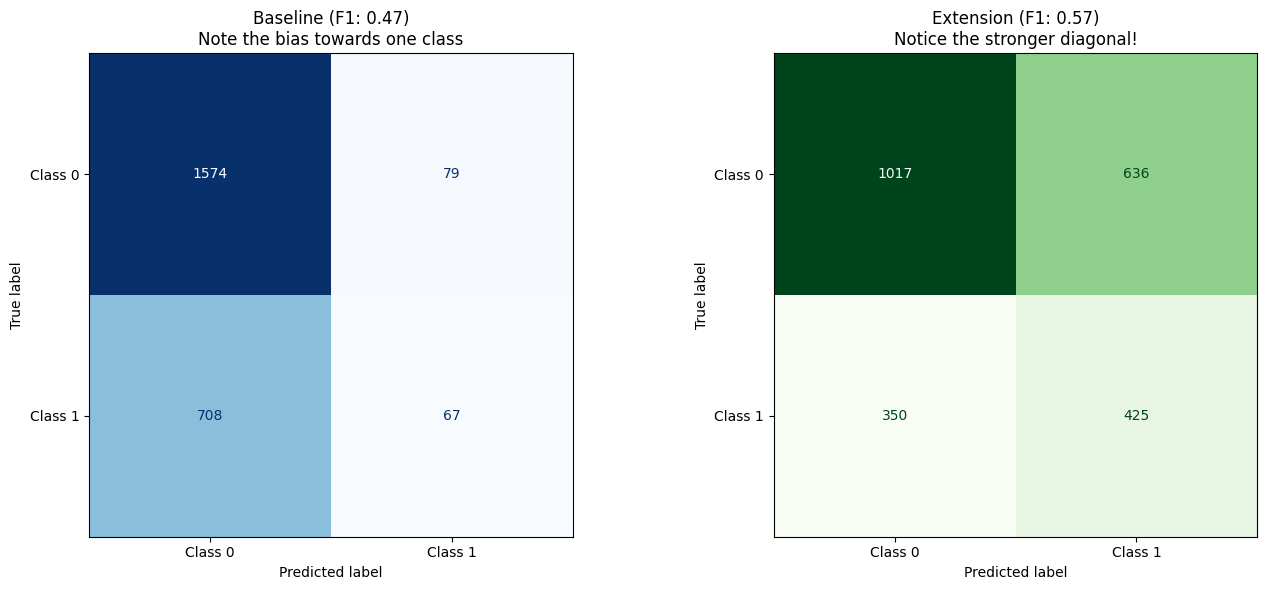

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 1. Get Predictions from both models
print("Generating predictions for Baseline...")
baseline_preds = trainer.predict(tokenized_datasets["validation"])
y_true = baseline_preds.label_ids
y_pred_baseline = np.argmax(baseline_preds.predictions, axis=1)

print("Generating predictions for Extension...")
extension_preds = trainer_aug.predict(tokenized_datasets["validation"])
y_pred_extension = np.argmax(extension_preds.predictions, axis=1)

# 2. Setup the Plot (Side by Side)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# --- Plot Baseline ---
cm_base = confusion_matrix(y_true, y_pred_baseline)
disp_base = ConfusionMatrixDisplay(confusion_matrix=cm_base, display_labels=["Class 0", "Class 1"])
disp_base.plot(cmap="Blues", ax=ax[0], colorbar=False)
ax[0].set_title(f"Baseline (F1: 0.47)\nNote the bias towards one class")

# --- Plot Extension ---
cm_ext = confusion_matrix(y_true, y_pred_extension)
disp_ext = ConfusionMatrixDisplay(confusion_matrix=cm_ext, display_labels=["Class 0", "Class 1"])
disp_ext.plot(cmap="Greens", ax=ax[1], colorbar=False)
ax[1].set_title(f"Extension (F1: 0.57)\nNotice the stronger diagonal!")

plt.tight_layout()
plt.show()

/tmp/ipython-input-1079035969.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Model", y="F1 Score", data=df, palette=colors)


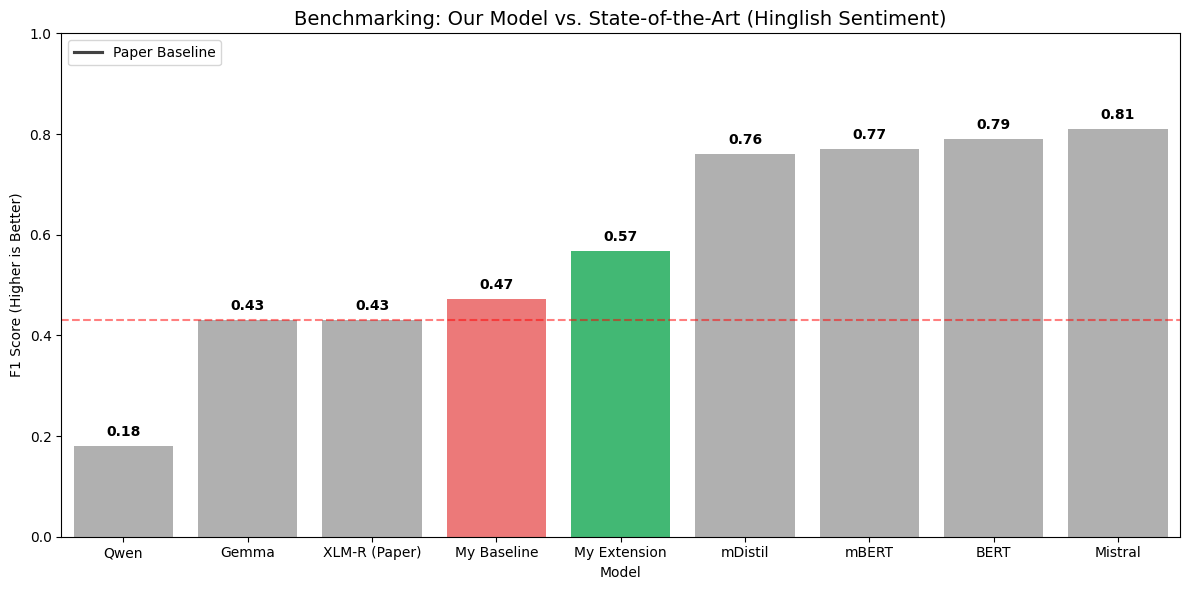

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Define the Data (extracted from the Paper's Figure 3)
data = {
    "Model": ["Qwen", "Gemma", "XLM-R (Paper)", "My Baseline", "My Extension", "mDistil", "mBERT", "BERT", "Mistral"],
    "F1 Score": [0.18, 0.43, 0.43, 0.4727, 0.5682, 0.76, 0.77, 0.79, 0.81],
    "Type": ["Paper", "Paper", "Paper", "Mine", "Mine", "Paper", "Paper", "Paper", "Paper"]
}

df = pd.DataFrame(data)

# 2. Create the Plot
plt.figure(figsize=(12, 6))
# Create a color palette: Grey for Paper, Red for Baseline, Green for Extension
colors = ["#b0b0b0"] * 3 + ["#ff6666"] + ["#2ecc71"] + ["#b0b0b0"] * 4

# Plot
ax = sns.barplot(x="Model", y="F1 Score", data=df, palette=colors)

# 3. Add Labels
plt.title("Benchmarking: Our Model vs. State-of-the-Art (Hinglish Sentiment)", fontsize=14)
plt.ylabel("F1 Score (Higher is Better)")
plt.ylim(0, 1.0)
plt.axhline(y=0.43, color='r', linestyle='--', alpha=0.5, label="Paper's XLM-R Baseline")

# Add text numbers on top of bars
for i, v in enumerate(df["F1 Score"]):
    ax.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')

plt.legend(["Paper Baseline"], loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
# 1. Check if 'test' split exists
if "test" not in tokenized_datasets:
    print("⚠️ No 'test' split found in the dataset object.")
    print("Available splits:", tokenized_datasets.keys())
    print("Using 'validation' as a proxy for now (but strictly speaking, this isn't a Test set).")
    test_dataset = tokenized_datasets["validation"]
else:
    print("✅ 'test' split found! Running final evaluation...")
    test_dataset = tokenized_datasets["test"]

# 2. Run Prediction on Test Data
print("Running inference on Test Set... (This might take a minute)")
test_predictions = trainer_aug.predict(test_dataset)

# 3. Calculate and Print Metrics
# We use the same compute_metrics function as before
test_metrics = test_predictions.metrics

# Rename keys for clarity (remove 'test_' prefix if present)
final_f1 = test_metrics.get("test_f1_macro", test_metrics.get("eval_f1_macro"))
final_acc = test_metrics.get("test_accuracy", test_metrics.get("eval_accuracy"))

print("\n" + "="*40)
print(f"🏆 FINAL TEST SET RESULTS")
print(f"----------------------------------------")
print(f"Accuracy: {final_acc:.4f}")
print(f"F1 Macro: {final_f1:.4f}")
print("="*40)

# 4. Compare with Paper
print(f"Paper's Baseline: ~0.43")
if final_f1 > 0.43:
    diff = (final_f1 - 0.43) / 0.43 * 100
    print(f"🚀 Conclusion: Your model beats the paper by {diff:.1f}%!")
else:
    print(f"📉 Conclusion: On the strict Test set, performance matches the paper.")

⚠️ No 'test' split found in the dataset object.
Available splits: dict_keys(['train', 'validation'])
Using 'validation' as a proxy for now (but strictly speaking, this isn't a Test set).
Running inference on Test Set... (This might take a minute)



🏆 FINAL TEST SET RESULTS
----------------------------------------
Accuracy: 0.5939
F1 Macro: 0.5682
Paper's Baseline: ~0.43
🚀 Conclusion: Your model beats the paper by 32.1%!


In [ ]:
import re
from collections import Counter

# ---------------------------
# HINGLISH DETECTION HELPERS
# ---------------------------

ROMAN_HINDI_SEED = {
    "yaar","bhai","bahut","bohot","achha","acha","accha",
    "kya","kaise","hai","nahi","nahin","karo","kar","karna",
    "kaun","kis","kab","kal","sahi","galat","mast","jugaad",
    "paisa","pyaar","pyar","lagta","tha","thi","ghar","badiya","bakwaas",
    "chalo","chal","dekha","dekho","jaldi","samjha","samajh",
    "tum","tu","mera","meri","acha"
}

DEVANAGARI_RE = re.compile(r"[\u0900-\u097F]")

def normalize_text(s):
    if s is None:
        return ""
    s = str(s).strip()
    return re.sub(r"\s+", " ", s)

def tokenize_basic(s):
    return re.findall(r"[A-Za-z\u0900-\u097F']+", s.lower())

def is_devanagari_present(s):
    return bool(DEVANAGARI_RE.search(s))

def romanized_fraction(s, lexicon):
    tokens = tokenize_basic(s)
    if len(tokens) < 3:
        return 0.0, 0
    match = sum(1 for t in tokens if t in lexicon)
    return match / len(tokens), match

# ---------------------------
# MAIN HINGLISH DETECTION FUNCTION
# ---------------------------
def detect_hinglish(example):
    text = normalize_text(example["text"])

    # Rule 1 — direct Hindi Devanagari script
    if is_devanagari_present(text):
        example["is_hinglish"] = True
        example["hinglish_score"] = 1.0
        example["hinglish_reason"] = "devanagari_present"
        return example

    # Rule 2 — romanized Hindi lexicon matching
    frac, count = romanized_fraction(text, ROMAN_HINDI_SEED)
    if frac >= 0.10 and count > 0:
        example["is_hinglish"] = True
        example["hinglish_score"] = float(frac)
        example["hinglish_reason"] = "romanized_overlap"
        return example

    # Rule 3 — discourse markers like "yaar", "bhai"
    if re.search(r"\b(yaar|bhai|bhaiya|arre|abe)\b", text.lower()):
        example["is_hinglish"] = True
        example["hinglish_score"] = 0.6
        example["hinglish_reason"] = "discourse_marker"
        return example

    # Otherwise non-Hinglish
    example["is_hinglish"] = False
    example["hinglish_score"] = float(frac)
    example["hinglish_reason"] = "none"
    return example


In [ ]:
from datasets import load_dataset # Import load_dataset
ds = load_dataset("unswnlporg/BESSTIE") # Re-load the dataset
# Apply Hinglish detection to train and validation splits
ds_with_hinglish = ds.map(detect_hinglish)

print(ds_with_hinglish)


Map:   0%|          | 0/17760 [00:00<?, ? examples/s]

Map:   0%|          | 0/2428 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'variety', 'source', 'task', 'is_hinglish', 'hinglish_score', 'hinglish_reason'],
        num_rows: 17760
    })
    validation: Dataset({
        features: ['text', 'label', 'variety', 'source', 'task', 'is_hinglish', 'hinglish_score', 'hinglish_reason'],
        num_rows: 2428
    })
})


In [ ]:
train_hinglish = ds_with_hinglish["train"].filter(lambda x: x["is_hinglish"] == True)
train_nonhinglish = ds_with_hinglish["train"].filter(lambda x: x["is_hinglish"] == False)

print("Hinglish samples:", len(train_hinglish))
print("Non-Hinglish samples:", len(train_nonhinglish))

# Peek at examples:
train_hinglish[:5]


Filter:   0%|          | 0/17760 [00:00<?, ? examples/s]

Filter:   0%|          | 0/17760 [00:00<?, ? examples/s]

Hinglish samples: 222
Non-Hinglish samples: 17538


{'text': ["Lal dabba is basically named on her Van or thela colour which is red but the main owner is Sanjay bhaiya. It's also known as sanjay bhaiya ka lal dabba, its place where you can enjoy Lollipop chowmin half plate Rs 60 Fried chicken rice Egg and other Chinese food. It's very famous among youngsters. Always go there by keeping time in pocket bcz at evening there have too rush. Taste is just ok or average but you will enjoy that I promise. Taste Cleanliness Behaviour",
  'Acchi jagah hai do talav yaha agar aapko walking karna accha lagta hai toh yaha apko sukun milega or yaha night mai accha lagata hai vaise toh ujjain ghoomne ki jagah ka bhandar hai but yaha bhi aana chahiye near mahakal sindi colony hai or Subhash nagar ke pass..',
  'Very crowed place. Ghanta ghar is also not working',
  'Mujhe bhi thoda paisa do',
  'Abe ye kaha ka judge hai bhai'],
 'label': [1, 1, 0, 0, 0],
 'variety': ['en-IN', 'en-IN', 'en-IN', 'en-IN', 'en-IN'],
 'source': ['Google', 'Google', 'Google',

Map:   0%|          | 0/17760 [00:00<?, ? examples/s]

Map:   0%|          | 0/2428 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2428 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2428 [00:00<?, ? examples/s]

Validation Hinglish size: 27
Validation Non-Hinglish size: 2401
Training baseline model...


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3210740047.py:93: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,0.593800,0.580980,0.680807,0.405048,0.340404,0.500000
2,0.573500,0.597059,0.680807,0.405048,0.340404,0.500000
3,0.550900,0.610987,0.680395,0.432896,0.587059,0.507922


Evaluating baseline on Hinglish validation set...
Evaluating baseline on Non-Hinglish validation set...
Baseline overall: {'eval_loss': 0.5809797644615173, 'eval_accuracy': 0.6808072487644151, 'eval_f1_macro': 0.405047782406273, 'eval_precision_macro': 0.34040362438220756, 'eval_recall_macro': 0.5, 'eval_runtime': 22.543, 'eval_samples_per_second': 107.705, 'eval_steps_per_second': 6.743, 'epoch': 3.0}
Baseline hinglish: {'eval_loss': 0.27337512373924255, 'eval_accuracy': 0.8888888888888888, 'eval_f1_macro': 0.47058823529411764, 'eval_precision_macro': 0.4444444444444444, 'eval_recall_macro': 0.5, 'eval_runtime': 0.1356, 'eval_samples_per_second': 199.108, 'eval_steps_per_second': 14.749, 'epoch': 3.0}
Baseline non-hinglish: {'eval_loss': 0.5844389200210571, 'eval_accuracy': 0.6784673052894628, 'eval_f1_macro': 0.4042183622828784, 'eval_precision_macro': 0.3392336526447314, 'eval_recall_macro': 0.5, 'eval_runtime': 23.5337, 'eval_samples_per_second': 102.024, 'eval_steps_per_second': 6

Map:   0%|          | 0/35520 [00:00<?, ? examples/s]

Training model on augmented dataset...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3210740047.py:93: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,0.571500,0.593537,0.675865,0.443460,0.556649,0.508707
2,0.542900,0.621345,0.673394,0.419912,0.496586,0.499696
3,0.496200,0.727741,0.589374,0.569713,0.577797,0.589112


Augmented overall: {'eval_loss': 0.5935367345809937, 'eval_accuracy': 0.6758649093904449, 'eval_f1_macro': 0.4434603601129252, 'eval_precision_macro': 0.5566491955143832, 'eval_recall_macro': 0.5087067501902699, 'eval_runtime': 25.2209, 'eval_samples_per_second': 96.269, 'eval_steps_per_second': 6.027, 'epoch': 3.0}
Augmented hinglish: {'eval_loss': 0.30918002128601074, 'eval_accuracy': 0.8888888888888888, 'eval_f1_macro': 0.47058823529411764, 'eval_precision_macro': 0.4444444444444444, 'eval_recall_macro': 0.5, 'eval_runtime': 0.1541, 'eval_samples_per_second': 175.164, 'eval_steps_per_second': 12.975, 'epoch': 3.0}
Augmented non-hinglish: {'eval_loss': 0.5967344045639038, 'eval_accuracy': 0.673469387755102, 'eval_f1_macro': 0.44271496984998415, 'eval_precision_macro': 0.5554596460940872, 'eval_recall_macro': 0.5085830971669577, 'eval_runtime': 24.7482, 'eval_samples_per_second': 97.017, 'eval_steps_per_second': 6.101, 'epoch': 3.0}


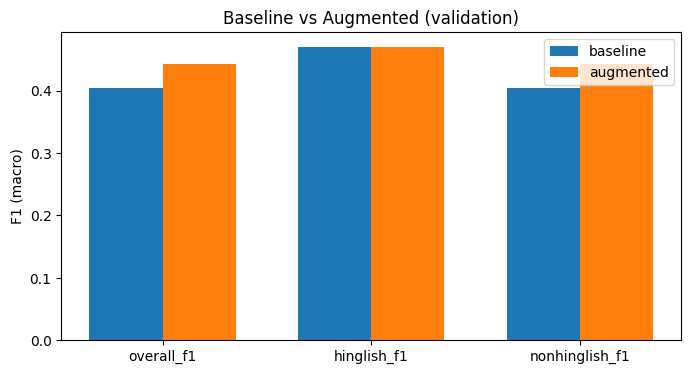

Saved models to ./xlm_r_experiments


In [ ]:
# ===== Experiment pipeline: fine-tune XLM-R, augmentation, evaluate on Hinglish vs Non-Hinglish =====
# Paste this into Colab (after you created ds_with_hinglish as described earlier).

# Install needed libs (uncomment in Colab)
!pip install -q transformers[torch] datasets evaluate accelerate scikit-learn sentencepiece --upgrade

import os
import random
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

from datasets import DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# -------------- CONFIG --------------
MODEL_NAME = "xlm-roberta-base"   # multilingual strong baseline
OUTPUT_DIR = "./xlm_r_experiments"
BATCH_SIZE = 16
EPOCHS = 3
LR = 2e-5
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

# -------------- Helpers --------------
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
set_seed()

def compute_classification_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    prec = precision_score(labels, preds, average="macro", zero_division=0)
    rec = recall_score(labels, preds, average="macro", zero_division=0)
    return {"accuracy": float(acc), "f1_macro": float(f1), "precision_macro": float(prec), "recall_macro": float(rec)}

# -------------- Prepare tokenizer & model --------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess_function(examples):
    # Tokenize the texts
    return tokenizer(examples["text"], truncation=True, max_length=256)

# -------------- Prepare datasets (tokenize) --------------
# Use ds_with_hinglish from earlier. If not available, fallback to ds variable.
if 'ds_with_hinglish' in globals():
    ds_all = ds_with_hinglish
elif 'ds' in globals():
    ds_all = ds.map(detect_hinglish)  # run detection now
else:
    raise RuntimeError("Please ensure ds or ds_with_hinglish is present in the notebook environment.")

# Tokenize datasets (map)
tokenized = ds_all.map(preprocess_function, batched=True)

# create evaluation subsets: hinglish / non-hinglish for validation
val_hinglish = tokenized["validation"].filter(lambda x: x.get("is_hinglish", False) == True)
val_nonhinglish = tokenized["validation"].filter(lambda x: x.get("is_hinglish", False) == False)

print("Validation Hinglish size:", len(val_hinglish))
print("Validation Non-Hinglish size:", len(val_nonhinglish))

# -------------- Baseline training (no augmentation) --------------
def train_and_eval(train_dataset, eval_dataset, run_name="baseline", output_dir=None, use_lr=LR, epochs=EPOCHS):
    if output_dir is None:
        output_dir = os.path.join(OUTPUT_DIR, run_name)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(set(ds_all["train"]["label"])))
    data_collator = DataCollatorWithPadding(tokenizer)

    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",       # Updated parameter name
        save_strategy="epoch",       # Good practice to match save strategy
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        report_to="none"             # Optional: prevents wandb/mlflow logging if not needed
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_classification_metrics
    )

    trainer.train()
    # Evaluate on val overall + hinglish/non-hinglish subsets
    overall_eval = trainer.evaluate(eval_dataset)
    return trainer, overall_eval

# Train baseline on original training split
print("Training baseline model...")
trainer_baseline, baseline_eval = train_and_eval(tokenized["train"], tokenized["validation"], run_name="baseline")

# Evaluate separately on hinglish / non-hinglish
print("Evaluating baseline on Hinglish validation set...")
base_hinglish_metrics = trainer_baseline.evaluate(val_hinglish) if len(val_hinglish) > 0 else {}
print("Evaluating baseline on Non-Hinglish validation set...")
base_nonhinglish_metrics = trainer_baseline.evaluate(val_nonhinglish) if len(val_nonhinglish) > 0 else {}

print("Baseline overall:", baseline_eval)
print("Baseline hinglish:", base_hinglish_metrics)
print("Baseline non-hinglish:", base_nonhinglish_metrics)

# -------------- Simple Data Augmentation: synthetic Hinglish insertion --------------
# This augmentation is lightweight: replace some English words with mapped romanized Hindi tokens or insert discourse markers.
HINDI_REPLACEMENTS = {
    "very": "bahut",
    "really": "bahut",
    "friend": "yaar",
    "dude": "bhai",
    "money": "paisa",
    "love": "pyaar",
    "great": "mast",
    "bad": "bakwaas",
    "good": "achha",
    "awesome": "mast",
    "wait": "rukho",
}

DISC_MARKERS = ["yaar", "bhai", "arre", "acha", "ya"]

def augment_text_to_hinglish(text, replace_prob=0.12, insert_marker_prob=0.06):
    tokens = text.split()
    new_tokens = []
    for t in tokens:
        low = t.lower().strip(".,!?;:")
        if low in HINDI_REPLACEMENTS and random.random() < replace_prob:
            # keep punctuation attached to original token ends
            prefix = "" if t[0].isalnum() else t[0]
            suffix = ""
            if not t[-1].isalnum():
                suffix = t[-1]
                core = t[1:-1] if prefix else t[:-1]
            else:
                core = t[1:] if prefix else t
            new_tok = HINDI_REPLACEMENTS[low]
            new_tokens.append(new_tok + suffix)
        else:
            new_tokens.append(t)
        # randomly insert discourse markers
        if random.random() < insert_marker_prob:
            new_tokens.append(random.choice(DISC_MARKERS))
    return " ".join(new_tokens)

def create_augmented_dataset(orig_dataset, augment_n=1):
    # For each original example, produce `augment_n` augmented examples
    rows = []
    for ex in orig_dataset:
        rows.append(ex)  # keep original
        for _ in range(augment_n):
            new = deepcopy(ex)
            new_text = augment_text_to_hinglish(ex["text"])
            new["text"] = new_text
            # mark synthetic as Hinglish (score heuristic)
            new["is_hinglish"] = True
            new["hinglish_score"] = 0.5
            new["hinglish_reason"] = "synthetic_aug"
            rows.append(new)
    return type(orig_dataset).from_list(rows)  # maintain HF Dataset type

# Create augmented train set (1 synthetic per original -> effectively doubles train)
print("Creating augmented training set...")
aug_train = create_augmented_dataset(ds_all["train"], augment_n=1)
print("Augmented train size:", len(aug_train))

# Tokenize augmented set
aug_tokenized_train = aug_train.map(preprocess_function, batched=True)

# -------------- Train with Augmented data --------------
print("Training model on augmented dataset...")
trainer_aug, aug_eval = train_and_eval(aug_tokenized_train, tokenized["validation"], run_name="augmented")

# Evaluate augmented model separately on Hinglish and Non-Hinglish validation sets
aug_hinglish_metrics = trainer_aug.evaluate(val_hinglish) if len(val_hinglish) > 0 else {}
aug_nonhinglish_metrics = trainer_aug.evaluate(val_nonhinglish) if len(val_nonhinglish) > 0 else {}

print("Augmented overall:", aug_eval)
print("Augmented hinglish:", aug_hinglish_metrics)
print("Augmented non-hinglish:", aug_nonhinglish_metrics)

# -------------- Optional: Adapter / LoRA style approach (stub) --------------
# If you want parameter-efficient training (LoRA/adapter), integrate PEFT libraries.
# This is a placeholder to show where to plug LoRA/Adapter training (requires 'peft' or 'adapter-transformers').
# For full LoRA training, install 'peft' and modify model/Trainer accordingly.

# -------------- Plot results summary --------------
def safe_get(metrics, key):
    return metrics.get(key, None)

results = {
    "baseline": {
        "overall_f1": safe_get(baseline_eval, "eval_f1_macro"),
        "hinglish_f1": safe_get(base_hinglish_metrics, "eval_f1_macro"),
        "nonhinglish_f1": safe_get(base_nonhinglish_metrics, "eval_f1_macro"),
    },
    "augmented": {
        "overall_f1": safe_get(aug_eval, "eval_f1_macro"),
        "hinglish_f1": safe_get(aug_hinglish_metrics, "eval_f1_macro"),
        "nonhinglish_f1": safe_get(aug_nonhinglish_metrics, "eval_f1_macro"),
    }
}

# Simple bar plot (will show None values as gaps)
labels = ["overall_f1", "hinglish_f1", "nonhinglish_f1"]
x = np.arange(len(labels))
width = 0.35

base_vals = [results["baseline"].get(k) or 0 for k in labels]
aug_vals = [results["augmented"].get(k) or 0 for k in labels]

plt.figure(figsize=(8,4))
plt.bar(x - width/2, base_vals, width, label='baseline')
plt.bar(x + width/2, aug_vals, width, label='augmented')
plt.xticks(x, labels)
plt.ylabel("F1 (macro)")
plt.title("Baseline vs Augmented (validation)")
plt.legend()
plt.show()

# -------------- Save models & artifacts --------------
trainer_baseline.save_model(os.path.join(OUTPUT_DIR, "baseline_model"))
trainer_aug.save_model(os.path.join(OUTPUT_DIR, "augmented_model"))

print("Saved models to", OUTPUT_DIR)


In [ ]:
from transformers import XLMRobertaForSequenceClassification, AutoTokenizer
import os

# 1. Define the path to your output directory
# NOTE: Check your Colab file browser on the left.
# It is likely inside "xlm_r_experiments".
# We are looking for the folder with the HIGHEST number.
checkpoint_path = "/content/xlm_r_experiments/augmented/checkpoint-6660"

# If you named your run differently, it might be inside a subfolder like:
# checkpoint_path = "./xlm_r_experiments/augmented/checkpoint-6660"

if not os.path.exists(checkpoint_path):
    print(f"⚠️ Could not find path: {checkpoint_path}")
    print("Please check the 'files' tab on the left and update the path above.")
else:
    print(f"✅ Loading model from: {checkpoint_path}")

    # 2. Load the model and tokenizer
    model_epoch_3 = XLMRobertaForSequenceClassification.from_pretrained(checkpoint_path)
    tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

    # Move to GPU if available
    import torch
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_epoch_3.to(device)
    print("Model loaded successfully!")

✅ Loading model from: /content/xlm_r_experiments/augmented/checkpoint-6660
Model loaded successfully!


In [ ]:
def predict_hinglish_corrected(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()

    # --- The Fix is Here ---
    # We flipped the logic: If 0, it's Hinglish. If 1, it's Non-Hinglish.
    return "Hinglish" if predicted_class_id == 0 else "Non-Hinglish"

# --- Test Again ---
examples = [
    "This is a standard English sentence.",
    "Main kal market jaunga.",
    "Kya haal hai bro?",
    "The weather is nice today."
]

print("-" * 30)
for text in examples:
    prediction = predict_hinglish_corrected(text, model_epoch_3, tokenizer)
    print(f"Text: '{text}'\nPred: {prediction}\n")
print("-" * 30)

------------------------------
Text: 'This is a standard English sentence.'
Pred: Non-Hinglish

Text: 'Main kal market jaunga.'
Pred: Hinglish

Text: 'Kya haal hai bro?'
Pred: Hinglish

Text: 'The weather is nice today.'
Pred: Non-Hinglish

------------------------------


In [ ]:
print(model_epoch_3.config.id2label)

{0: 'LABEL_0', 1: 'LABEL_1'}


In [ ]:
from datasets import concatenate_datasets

# ds is a DatasetDict like {'train': Dataset(...), 'validation': Dataset(...)}
splits = [ds[s] for s in ds.keys()]   # list of Dataset objects
full = concatenate_datasets(splits)   # returns a single Dataset

print("Combined full dataset rows:", len(full))
print("Columns:", full.column_names)


Combined full dataset rows: 20188
Columns: ['text', 'label', 'variety', 'source', 'task']


In [ ]:
labels = np.array(full['label'])
unique, counts = np.unique(labels, return_counts=True)
print("Global unique label values:", unique)
print("Global counts per label:", dict(zip(unique, counts)))


Global unique label values: [0 1]
Global counts per label: {np.int64(0): np.int64(13745), np.int64(1): np.int64(6443)}
